In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en')

import tweepy
import os
import csv
import re
import time
import pickle
import preprocessor as p
import itertools
from collections import Counter
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Gathering Tweets with Twitter API (Tweepy)

In [2]:
keys = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/twitterkeys.csv')

In [3]:
ckey = keys.consumer_key[0]
csecret = keys.consumer_secret[0]
atoken = keys.access_token[0]
asecret = keys.access_secret[0]

auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [4]:
def get_tweets(user):    
    tweetlist = []
    tweets = api.user_timeline(screen_name=user, count=200, include_rts=False)
    tweetlist.extend(tweets)
    lastweet = tweetlist[-1].id-1
    
    while len(tweets) > 0:
        tweets = api.user_timeline(screen_name=user, count=200, include_rts=False, max_id=lastweet)
        tweetlist.extend(tweets)
        lastweet = tweetlist[-1].id-1
        print(len(tweetlist), ' downloaded so far')
    
    outtweets = [[tweet.text.encode('utf-8')] for tweet in tweetlist]
    print(outtweets)
    with open (' {}.csv'.format(user), 'w') as f:
        writer = csv.writer(f)
        writer.writerows('t')
        writer.writerows(outtweets)
#Code sourced from https://gist.github.com/yanofsky/5436496

get_tweets('justinbieber')

get_tweets('jtimberlake')
get_tweets('zaynmalik')
get_tweets('chrisbrown')
get_tweets('brunomars')
get_tweets('selenagomez')
get_tweets('ddlovato')
get_tweets('aliciakeys')
get_tweets('ladygaga')
get_tweets('katyperry')


In [6]:
jb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/justinbieber.csv')
jt = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/jtimberlake.csv')
zm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/zaynmalik.csv')
cb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/chrisbrown.csv')
bm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/brunomars.csv')
sg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/selenagomez.csv')
dl = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ddlovato.csv')
ak = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/aliciakeys.csv')
lg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ladygaga.csv')
kp = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/katyperry.csv')

In [7]:
jb['artist'] = 'justinbieber'
jt['artist'] = 'justintimberlake'
zm['artist'] = 'zaynmalik'
cb['artist'] = 'chrisbrown'
bm['artist'] = 'brunomars'
sg['artist'] = 'selenagomez'
dl['artist'] = 'demilovato'
ak['artist'] = 'aliciakeys'
lg['artist'] = 'ladygaga'
kp['artist'] = 'katyperry'

In [106]:
artistlist = ['justinbieber', 'justintimberlake', 'zaynmalik', 'chrisbrown', 'brunomars', 'selenagomez', 'demilovato',
             'aliciakeys', 'ladygaga', 'katyperry']

In [8]:
jb.head()

,t,artist
0,b'All love over here Aaron. You got my support',justinbieber
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber
3,b'3 years ago today released #Purpose. Thank you',justinbieber
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber


In [9]:
print(zm.t[0])

b'Thank you @Spotify \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd \nhttps://t.co/DUMWKSiGYN https://t.co/RlQhR0gRLR'


In [10]:
b'\xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd'.decode()


'🙌🏽'

In [11]:
#Combine the tweets of all artists into one dataframe
alltweets = pd.concat([jb,jt,zm,cb,bm,sg,dl,ak,lg,kp])

In [12]:
#Preprocessor is a python package that preprocesses tweets by removing abundant useless information such as
#emojis urls and symbols.
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)
alltweets['cleaned'] = alltweets['t'].apply(lambda x: p.clean(x))
alltweets.cleaned = alltweets.cleaned.str.lower()
alltweets.cleaned = alltweets.cleaned.str.strip()
alltweets.cleaned = alltweets.cleaned.str.replace("b'", '')
alltweets.cleaned = alltweets.cleaned.str.replace('b"', '')

In [13]:
#Preprocessor doesnt seem to remove all emojis, and our data is still rather dirty.
def removeemoji(text):
    clean = re.sub(r'\\', '', text)
    clean = re.sub(r'(x..){3,}','',clean)
    return clean

def GetSpecialChar(x):
    special_characters = []
    for char in x:
        if char.isalpha() == False:
            special_characters.append(char)
    return special_characters

special_characters = alltweets.cleaned.apply(lambda x: GetSpecialChar(x))
special_characters = list(set(itertools.chain.from_iterable(special_characters)))
special_characters.remove(' ')

alltweets.cleaned = alltweets.cleaned.apply(lambda x: removeemoji(x))
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace("can't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("won't", '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\nhttps:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https://', '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https', '')
alltweets.cleaned = alltweets.cleaned.str.replace("n't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'t", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'s", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'re", '')
alltweets.cleaned = alltweets.cleaned.apply(lambda x: re.sub(r'(.)\1{3,}.*$', '', x)) #Removes words with 3+ repeating letters

for char in (special_characters):
    alltweets.cleaned = alltweets.cleaned.str.replace(char, '')
alltweets.cleaned = alltweets.cleaned.str.strip()

alltweets

,t,artist,cleaned
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song
6,b'https://t.co/Ehx7cDu0Nw',justinbieber,
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day


In [14]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
alltweets['tokenized'] = alltweets.cleaned.apply(lambda x: word_tokenize(x))
def removestop(x):
    newlist = []
    for w in x:
        if w not in stopwords and len(w)>1: # Appends words w/ len >1 that are not stop-words to new tokenized list
            w = lem.lemmatize(w)
            newlist.append(w)
    return newlist

alltweets['tokenized'] = alltweets.tokenized.apply(lambda x: removestop(x))
alltweets

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,"[love, aaron, got, support]"
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,"[aaron, carter, album, little, bumped, song, aaron, party, like, need, hype, man, got]"
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,"[xkarla, donate, portion, proceeds, humane, society, help, animal, hurt, displaced, fire]"
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,"[year, ago, today, released, purpose, thank]"
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,"[thank, next, bop, favorite, song, least, song, smash, fire]"
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song,"[congrats, new, song]"
6,b'https://t.co/Ehx7cDu0Nw',justinbieber,,[]
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible,"[listened, album, time, row, incredible]"
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh,"[praying, pittsburgh]"
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day,"[wishing, everyone, amazing, day]"


In [15]:
alltweets.tokenized = alltweets.tokenized.apply(lambda x: ' '.join(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [16]:
#Remove empty tweets
finaltweets = alltweets[(alltweets.tokenized !='')&(alltweets.tokenized!=' ')]
finaltweets

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song,congrats new song
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible,listened album time row incredible
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh,praying pittsburgh
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day,wishing everyone amazing day
10,b'Wow 3 years. Thanks https://t.co/1ou2v3MbCA',justinbieber,wow years thanks,wow year thanks


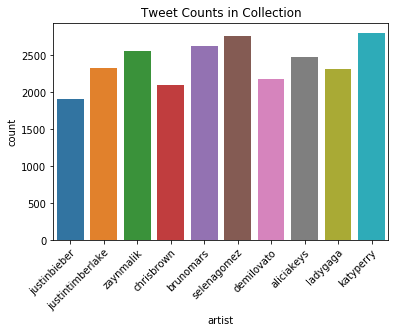

Tweets per Artist 

 katyperry           2797
selenagomez         2753
brunomars           2617
zaynmalik           2555
aliciakeys          2480
justintimberlake    2332
ladygaga            2316
demilovato          2174
chrisbrown          2096
justinbieber        1901
Name: artist, dtype: int64


In [17]:
sns.countplot(x=finaltweets.artist, data=finaltweets)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Tweet Counts in Collection')
plt.show()
print('Tweets per Artist','\n\n',finaltweets.artist.value_counts())

In [18]:
finaltweets['numwords'] = finaltweets.cleaned.apply(lambda x: len(x.split()))
finaltweets.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,t,artist,cleaned,tokenized,numwords
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15


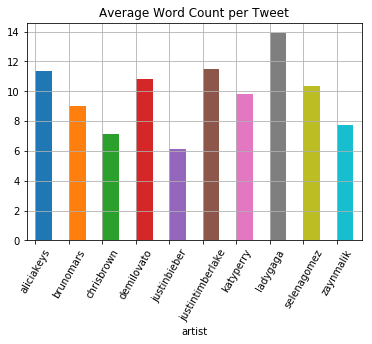

In [19]:
finaltweets.groupby('artist')['numwords'].mean().plot(kind='bar', rot=60, position=.01, grid=True)
plt.title('Average Word Count per Tweet')
plt.show()

In [20]:
#Gets the punctuation count to use as a feature.
def periodcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def questioncount(x):
    n = 0
    for char in x:
        if char == '?':
            n+=1
    return n

def exclaimcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def hashcount(x):
    n=0
    for char in x:
        if char == '#':
            n+=1
    return n

def mentioncount(x):
    n=0
    for char in x:
        if char == '@':
            n+=1
    return n

In [21]:
finaltweets['hashcount'] = finaltweets.t.apply(lambda x: hashcount(x))
finaltweets['mentioncount'] = finaltweets.t.apply(lambda x: mentioncount(x))

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
finaltweets.head()

,t,artist,cleaned,tokenized,numwords,hashcount,mentioncount
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9,0,0
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28,0,0
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20,0,0
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7,1,0
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15,0,0


# Bag of Words Model w/ Count Vectorizer

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


In [24]:
X = finaltweets['tokenized']
Y = finaltweets['artist']

In [25]:
vectorizer = CountVectorizer()
vectorizer.fit(X)
Xdtm = vectorizer.transform(X)
Xdtm

<24021x16387 sparse matrix of type '<class 'numpy.int64'>'
	with 131989 stored elements in Compressed Sparse Row format>

In [26]:
features = pd.DataFrame(Xdtm.toarray(), columns=vectorizer.get_feature_names())
features.shape

(24021, 16387)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(Xdtm, Y, test_size=.3, random_state=0)

In [142]:
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train, y_train)
print('Training ACC score:', lgr.score(X_train, y_train))
print(' Testing ACC score:', lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('\nClassification Report\n', classification_report(y_test, predy))

Training ACC score: 0.8576781253717141
 Testing ACC score: 0.5572360205355904

Cross-Tab
 [[347  15  59  13  48  41  13  11  10  39]
 [ 25 354  54   8  58  57  19  27  24  71]
 [ 34  26 445  13  72  56  31  20   8  66]
 [ 27   9  18 467  36  22  11  16   6  48]
 [ 35  22  67  12 400  65  27  18  20  91]
 [ 40  19  71  12  83 424  32  26  41  83]
 [ 19  23  52  11  55  63 287  36  20  75]
 [ 18  22  29   6  22  41  27 452  30  72]
 [ 24   7  33   8  53  56  27  40 366  83]
 [ 22  22  64  16  74  45  43  41  37 474]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.66      0.63      0.64       719
       brunomars       0.44      0.53      0.48       757
      chrisbrown       0.83      0.71      0.76       660
      demilovato       0.56      0.45      0.50       641
    justinbieber       0.59      0.58      0.58       596
justintimberlake       0.68      0.51      0.58       697
       katyperry       0.43      0.57      0.49 

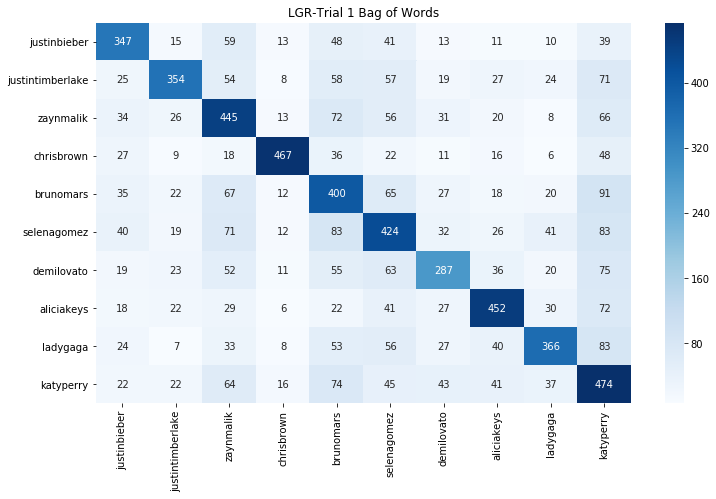

In [144]:
conf1 = confusion_matrix(y_test, predy, labels = artistlist)
df_lgr1 = pd.DataFrame(conf1, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr1, annot=True, cmap='Blues', fmt = 'd')
plt.title('LGR-Trial 1 Bag of Words')
plt.show()

The first run with logistic regression gave us a decent score of 55.7% accuracy. I can probably improve on this by adding features present in each tweet to the algorithms. Below I'm going to add punctuation counts, word counts, hash counts, and mention counts to the featureset. I included hashs and @ symbols because they are commonly used in twitter to signify trending topics or mention other users.

# Bag of Words with new Features

In [29]:
#Create some new features to try to improve predictions
#Punctuation count
#Length of tweet
finaltweets2 = pd.DataFrame() #make copy of tweets for testing
finaltweets2['p_1'] = finaltweets.t.apply(lambda x: periodcount(x))
finaltweets2['q_1'] = finaltweets.t.apply(lambda x: questioncount(x))
finaltweets2['e_1'] = finaltweets.t.apply(lambda x: exclaimcount(x))
#length of raw tweet
finaltweets2['c_1'] = finaltweets.t.apply(lambda x: len(x))
#Length of tweet w/ stopwords and special characters removed
finaltweets2['c_2'] = finaltweets.tokenized.apply(lambda x: len(x))
finaltweets2['hashcount'] = finaltweets.t.apply(lambda x: hashcount(x))
finaltweets2['mentioncount'] = finaltweets.t.apply(lambda x: mentioncount(x))
finaltweets2['numwords'] = finaltweets['numwords']
finaltweets2.head(20)

,p_1,q_1,e_1,c_1,c_2,hashcount,mentioncount,numwords
0,1,0,1,47,22,0,0,9
1,4,0,4,146,72,0,0,28
2,1,0,1,149,77,0,0,20
3,1,0,1,49,37,1,0,7
4,3,0,3,76,50,0,0,15
5,0,0,0,44,17,0,1,5
7,1,0,1,73,34,0,1,11
8,0,0,0,25,18,0,0,3
9,0,0,0,34,28,0,0,5
10,2,0,2,46,15,0,0,3


In [30]:
finaltweets2.shape

(24021, 8)

In [31]:
#Concat original X with new features
X2 = pd.DataFrame.merge(features, finaltweets2, how='outer', on=features.index)

In [32]:
X2.drop(columns='key_0', inplace=True)
X2.head()

,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zurich,zuzu,p_1,q_1,e_1,c_1,c_2,hashcount,mentioncount,numwords
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,47,22,0,0,9
1,0,0,0,0,0,0,0,0,0,2,...,0,0,4,0,4,146,72,0,0,28
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,149,77,0,0,20
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,49,37,1,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,76,50,0,0,15


In [33]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [34]:
lgr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nCross-Tab\n',confusion_matrix(y_test2, predy2))
print('\nClassification Report\n', classification_report(y_test2, predy2))

Training ACC score: 0.30771975734506957
 Testing ACC score: 0.3038712362980436

Cross-Tab
 [[289   4  23   0  16  60 157  93  66  11]
 [ 41  85  17   0  24  90  85  56 169 190]
 [ 77  26 184   0  11 117  46  65  93  41]
 [135  17  12   3  14  67 136  96  78  83]
 [ 22  53  56   0  52 140  25   6 135 107]
 [ 69  26  16   0  50 265  75  77 107  12]
 [101  21  15   0  12  60 307 103  93 126]
 [ 86  19  18   0   4  66 101 242 103  58]
 [ 48  27  10   1  38 113  88 114 307  85]
 [ 24  15   6   0  28  28  80  52  82 456]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.32      0.40      0.36       719
       brunomars       0.29      0.11      0.16       757
      chrisbrown       0.52      0.28      0.36       660
      demilovato       0.75      0.00      0.01       641
    justinbieber       0.21      0.09      0.12       596
justintimberlake       0.26      0.38      0.31       697
       katyperry       0.28      0.37      0.32

The newly added features seemed to have tanked the accuracy scores. This is probably because the new features are on an entirely different scale from each other. I will use standardscaler to scale all continuous features.

In [35]:
#We now have continuous features that need to be standardized
scaler = StandardScaler()
scaled = scaler.fit_transform(finaltweets2)
scaled = pd.DataFrame(scaled, columns = ['p_1', 'q_1', 'e_1', 'c_1', 'c_2', 'numwords', 'hashcount', 'mentioncount'])
X2 = features.merge(scaled, left_index=True, right_index=True, how='left')
X2.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zurich,zuzu,p_1,q_1,e_1,c_1,c_2,numwords,hashcount,mentioncount
0,0,0,0,0,0,0,0,0,0,1,...,0,0,-0.330187,-0.251006,-0.330187,-0.967206,-0.604652,-0.657743,-0.68864,-0.124450
1,0,0,0,0,0,0,0,0,0,2,...,0,0,1.655318,-0.251006,1.655318,0.951578,1.471080,-0.657743,-0.68864,2.650291
2,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.330187,-0.251006,-0.330187,1.009723,1.678653,-0.657743,-0.68864,1.481979
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.330187,-0.251006,-0.330187,-0.928443,0.018067,0.626886,-0.68864,-0.416528
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0.993483,-0.251006,0.993483,-0.405138,0.557758,-0.657743,-0.68864,0.751784


In [36]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [37]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nClassification Report\n', classification_report(y_test2, predy2))
print(time.time()-start)

Training ACC score: 0.8560128464374925
 Testing ACC score: 0.5924795337865963

Cross-Tab
 [[497  19   6  28  14  27  45  43  35   5]
 [ 13 401   9  17  50  40  57  15  62  93]
 [  9  40 469  15  30  12  34   9  22  20]
 [ 40  50   6 281  21  28  79  30  50  56]
 [  6  52   7   8 388  17  26   6  35  51]
 [ 27  40   5  19  25 426  47  28  61  19]
 [ 45  57  15  36  23  20 486  42  48  66]
 [ 43  51  12  28  16  18  75 382  40  32]
 [ 24  68  13  37  55  33  68  38 437  58]
 [ 10  75   8  20  30  20  45   7  53 503]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.70      0.69      0.69       719
       brunomars       0.47      0.53      0.50       757
      chrisbrown       0.85      0.71      0.78       660
      demilovato       0.57      0.44      0.50       641
    justinbieber       0.60      0.65      0.62       596
justintimberlake       0.66      0.61      0.64       697
       katyperry       0.51      0.58      0.54 

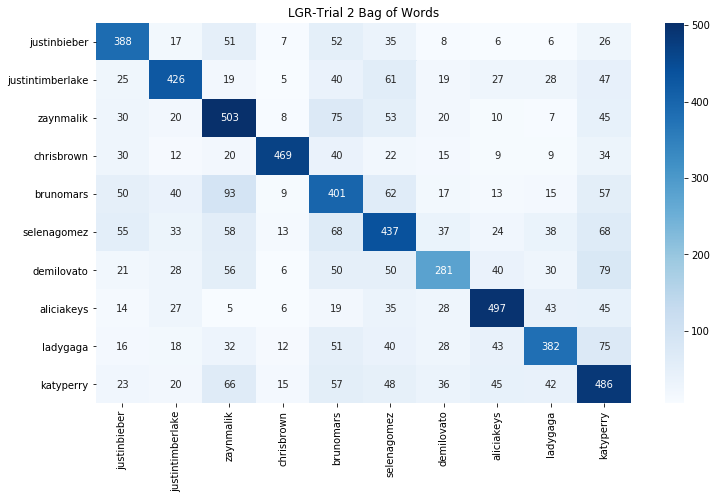

In [145]:
conf2 = confusion_matrix(y_test2, predy2, labels = artistlist)
df_lgr2 = pd.DataFrame(conf2, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr2, annot=True, cmap='Blues', fmt = 'd')
plt.title('LGR-Trial 2 Bag of Words')
plt.show()

In [38]:
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax', num_class=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train2, y_train2)
print(xgb.score(X_train2, y_train2))
print(xgb.score(X_test2, y_test2))
predxgb2 = xgb.predict(X_test2)
print('Cross-Tab\n\n',confusion_matrix(predxgb2, y_test2))
print('\nClassification Report\n\n', classification_report(y_test2, predxgb2))
print(time.time()-start)

0.858689187581777
0.5992784792562786
Cross-Tab

 [[500  18  13  36   4  32  59  45  26   8]
 [ 15 384  53  42  29  33  47  45  51  63]
 [  9  13 463  12  15   4   9   6  17  11]
 [ 23  19  18 279  10  13  24  33  31  18]
 [ 12  49  21   9 387  19  15  21  27  23]
 [ 32  36  15  30  20 456  24  22  42  24]
 [ 47  53  34  67  25  41 476  62  77  38]
 [ 41  16  10  42  10  30  42 378  39  10]
 [ 33  78  21  61  57  56  54  59 472  52]
 [  7  91  12  63  39  13  88  26  49 524]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.67      0.70      0.68       719
       brunomars       0.50      0.51      0.51       757
      chrisbrown       0.83      0.70      0.76       660
      demilovato       0.60      0.44      0.50       641
    justinbieber       0.66      0.65      0.66       596
justintimberlake       0.65      0.65      0.65       697
       katyperry       0.52      0.57      0.54       838
        ladygaga       0.61   

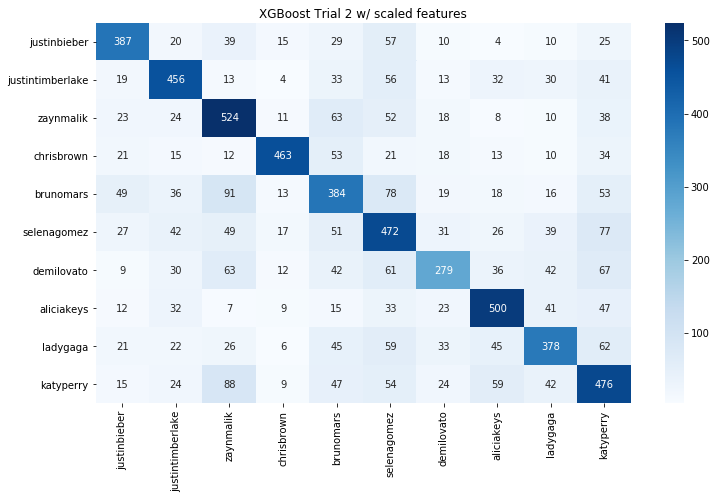

In [147]:
conf3 = confusion_matrix(y_test2, predxgb2, labels = artistlist)
df_lgr3 = pd.DataFrame(conf3, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr3, annot=True, cmap='Blues', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [39]:
from lightgbm import LGBMClassifier
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                        learning_rate=0.3, max_depth=4, min_child_samples=20,
                        min_child_weight=.01, min_split_gain=0, n_estimators=700,
                        n_jobs=-1, num_leaves=100, objective='multiclass:softmax', num_class=10, random_state=0,
                        reg_alpha=0, reg_lambda=1, silent=True, subsample=1,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train2, y_train2)
print(lgb.score(X_train2, y_train2))
print(lgb.score(X_test2, y_test2))
predlgb2 = lgb.predict(X_test2)
print('Cross-Tab\n\n',confusion_matrix(predlgb2, y_test2))
print('\nClassification Report\n\n', classification_report(y_test2, predlgb2))
print(time.time()-start)

0.7638277625788034
0.5432218676286943
Cross-Tab

 [[470  19  16  38   8  36  62  60  37   9]
 [ 16 335  50  49  31  37  51  35  64  84]
 [  5  13 445  24  18  11  11  10  23  11]
 [ 21  20  13 228  12  22  27  36  35  15]
 [ 19  50  31   8 373  24  22  26  34  20]
 [ 34  49  15  36  23 401  34  24  53  16]
 [ 47  64  30  76  27  47 433  73  79  50]
 [ 55  15  14  47   6  36  49 331  46   6]
 [ 43  95  30  74  57  63  63  65 411  72]
 [  9  97  16  61  41  20  86  37  49 488]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.62      0.65      0.64       719
       brunomars       0.45      0.44      0.44       757
      chrisbrown       0.78      0.67      0.72       660
      demilovato       0.53      0.36      0.43       641
    justinbieber       0.61      0.63      0.62       596
justintimberlake       0.59      0.58      0.58       697
       katyperry       0.47      0.52      0.49       838
        ladygaga       0.55  

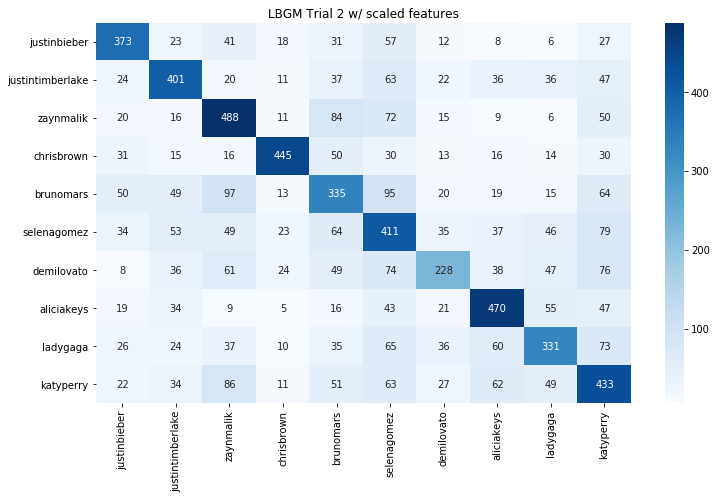

In [149]:
conf4 = confusion_matrix(y_test2, predlgb2, labels = artistlist)
df_lgr4 = pd.DataFrame(conf4, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr4, annot=True, cmap='Blues', fmt = 'd')
plt.title('LBGM Trial 2 w/ scaled features')
plt.show()

# TF-IDF Vectorization of Tweets

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_df=.5, min_df=2, stop_words='english',
                     lowercase=True, use_idf=True, norm=u'l2',
                     smooth_idf=True)
tweetstfid = tfid.fit_transform(finaltweets.tokenized)

In [153]:
X3 = pd.DataFrame(tweetstfid.toarray())

In [154]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y, test_size=.3, random_state=0)

In [155]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train3, y_train3)
print('Training ACC score:', lgr.score(X_train3, y_train3))
print(' Testing ACC score:', lgr.score(X_test3, y_test3))
predy3 = lgr.predict(X_test3)
print('\nCross-Tab\n',confusion_matrix(y_test3, predy3))
print('\nClassification Report\n', classification_report(y_test3, predy3))
print(time.time()-start)

Training ACC score: 0.7412275484715118
 Testing ACC score: 0.5600111003191341

Cross-Tab
 [[463  27   4  23   7  16  77  39  44  19]
 [ 20 381   8  21  27  34 103  26  79  58]
 [ 17  33 453   9  15  12  66   9  30  16]
 [ 46  57   7 268  22  21  85  30  70  35]
 [ 13  33   7   9 342  20  60  15  58  39]
 [ 31  50   3  22  20 354  78  31  65  43]
 [ 38  68  11  31  18  26 514  49  48  35]
 [ 51  49   3  22  13  13  96 380  51  19]
 [ 32  70  15  33  33  15  88  39 445  61]
 [ 32  57   6  22  25  36  80  12  65 436]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.62      0.64      0.63       719
       brunomars       0.46      0.50      0.48       757
      chrisbrown       0.88      0.69      0.77       660
      demilovato       0.58      0.42      0.49       641
    justinbieber       0.66      0.57      0.61       596
justintimberlake       0.65      0.51      0.57       697
       katyperry       0.41      0.61      0.49 

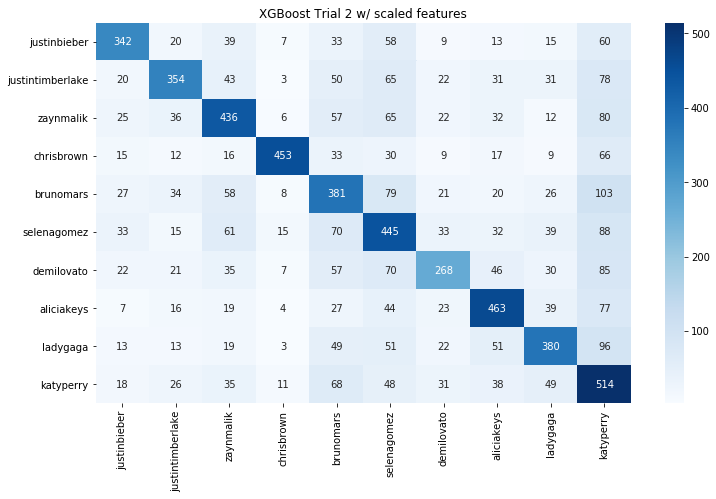

In [156]:
conf5 = confusion_matrix(y_test3, predy3, labels = artistlist)
df_lgr5 = pd.DataFrame(conf5, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr5, annot=True, cmap='Blues', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [85]:
X3.shape

(24021, 6913)

In [88]:
X3['artist'] = finaltweets.artist.values

In [90]:
X3.head()

,0,1,2,3,4,5,6,7,8,9,...,6904,6905,6906,6907,6908,6909,6910,6911,6912,artist
24016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,katyperry
24017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,katyperry
24018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,katyperry
24019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,katyperry
24020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,katyperry


# Work in Progress Cosine Similarity

In [107]:
#We can try to compare similarities in the artists' tweets by computing the cosine similarity.
#Here I get the average vector for each artist and compare the similarities between them.
meanvector = []
for artist in artistlist:
    artisttweets = []
    for tweet, art in zip(tweetstfid.toarray(), Y):
        if art == artist:
            artisttweets.append(tweet)
    #Now take the average of the tf-idf rows for this author
    meanvector.append([np.mean(artisttweets, axis = 0), artist])

In [108]:
artistlist

['justinbieber',
 'justintimberlake',
 'zaynmalik',
 'chrisbrown',
 'brunomars',
 'selenagomez',
 'demilovato',
 'aliciakeys',
 'ladygaga',
 'katyperry']

In [133]:
meanvector[1][0]

array([0.00054049, 0.0005339 , 0.        , ..., 0.        , 0.        ,
       0.00022182])

In [129]:
m = meanvector[0][0].reshape(-1,1)
n = meanvector[1][0].reshape(-1,1)


In [134]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity(m, n, dense_output=False))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Reducing Features with SVD

In [45]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

start = time.time()

pipe = Pipeline(steps=[('svd', TruncatedSVD(3000)), 
                       ('norm', Normalizer(copy=False))])
X3pipe = pipe.fit_transform(X3)

print(time.time()-start)

save_classifier = open('svd3000f.pickle','wb')

pickle.dump(X3pipe, save_classifier)
save_classifier.close()

In [46]:
svd3000load = open('svd3000f.pickle', 'rb')
X3pipe = pickle.load(svd3000load)
svd3000load.close()

#5000 features 97% explained variance
#3000 features 89% explained variance

pipe.get_params()['svd'].explained_variance_ratio_.sum()

In [157]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3pipe, Y, test_size=.3, random_state=0)

In [158]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train4, y_train4)
print('Training ACC score:', lgr.score(X_train4, y_train4))
print(' Testing ACC score:', lgr.score(X_test4, y_test4))
predy4 = lgr.predict(X_test4)
print('\nCross-Tab\n',confusion_matrix(y_test4, predy4))
print('\nClassification Report\n', classification_report(y_test4, predy4))
print(time.time()-start)

Training ACC score: 0.5766623052218389
 Testing ACC score: 0.5122797280421812

Cross-Tab
 [[434  15   1   9   6  76  48  67  35  28]
 [ 22 330   6   3  31  66  50  21  73 155]
 [ 16  47 417   3  19  24  32  25  31  46]
 [ 64  40   2 179  11  70  72  73  46  84]
 [ 12  41   6   6 305  34  16  13  39 124]
 [ 52  34   0   8  12 408  46  49  56  32]
 [ 88  45   4  10  15  52 368  73  50 133]
 [ 66  40   2   9   9  38  49 374  47  63]
 [ 24  72   9  14  43  91  57  68 353 100]
 [ 13  51   1   7  34  22  44  23  52 524]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.55      0.60      0.57       719
       brunomars       0.46      0.44      0.45       757
      chrisbrown       0.93      0.63      0.75       660
      demilovato       0.72      0.28      0.40       641
    justinbieber       0.63      0.51      0.56       596
justintimberlake       0.46      0.59      0.52       697
       katyperry       0.47      0.44      0.45 

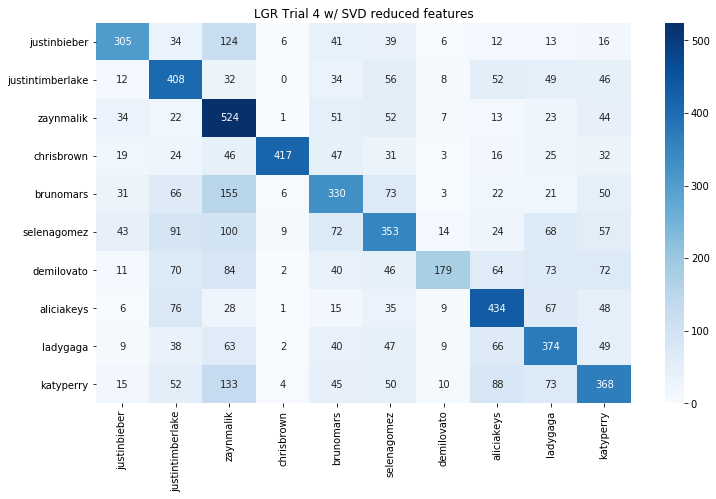

In [160]:
conf6 = confusion_matrix(y_test4, predy4, labels = artistlist)
df_lgr6 = pd.DataFrame(conf6, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr6, annot=True, cmap='Blues', fmt = 'd')
plt.title('LGR Trial 4 w/ SVD reduced features')
plt.show()

X_train3 = scipy.sparse.csc_matrix(X_train3)
X_test3 = scipy.sparse.csc_matrix(X_test3)

start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax',num_classes=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train3, y_train3)
print(xgb.score(X_train3, y_train3))
print(xgb.score(X_test3, y_test3))
predxgb3 = xgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predxgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predxgb3))
print(time.time()-start)

save_classifier = open('TweetsXGB1.pickle','wb')

pickle.dump(xgb, save_classifier)
save_classifier.close()

In [161]:
start = time.time()
xgbload = open('TweetsXGB1.pickle', 'rb')
xgb = pickle.load(xgbload)
xgbload.close()
print(xgb.score(X_train4, y_train4))
print(xgb.score(X_test4, y_test4))
predxgb4 = xgb.predict(X_test4)
print('Cross-Tab\n\n',confusion_matrix(predxgb4, y_test4))
print('\nClassification Report\n\n', classification_report(y_test4, predxgb4))
print(time.time()-start)

0.9930415130248602
0.5443318995421118
Cross-Tab

 [[457  18  19  56   5  43  70  58  25  19]
 [ 27 361  50  50  42  36  50  53  66  61]
 [  7  14 441  11  19   9  19  12  19   9]
 [ 25  29   6 237  16  28  42  29  45  19]
 [  6  31  14   8 332  13  22  13  21  28]
 [ 38  42  13  38  20 384  35  20  54  25]
 [ 64  72  28  72  24  44 431  64  59  53]
 [ 45  22  22  59  19  45  54 375  54  24]
 [ 32  85  37  57  64  65  52  47 431  59]
 [ 18  83  30  53  55  30  63  26  57 474]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.59      0.64      0.61       719
       brunomars       0.45      0.48      0.46       757
      chrisbrown       0.79      0.67      0.72       660
      demilovato       0.50      0.37      0.42       641
    justinbieber       0.68      0.56      0.61       596
justintimberlake       0.57      0.55      0.56       697
       katyperry       0.47      0.51      0.49       838
        ladygaga       0.52  

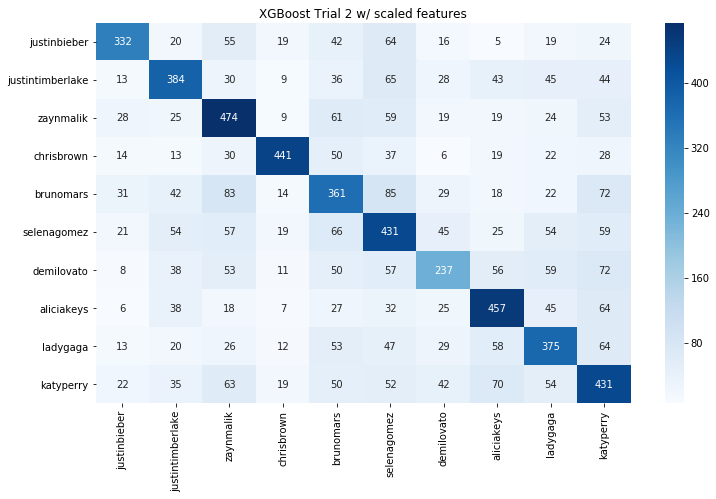

In [162]:
conf7 = confusion_matrix(y_test4, predxgb4, labels = artistlist)
df_lgr7 = pd.DataFrame(conf7, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr7, annot=True, cmap='Blues', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [50]:
#Add ratio of punctuation/characters

from lightgbm import LGBMClassifier

start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.3, max_depth=5, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
                        n_jobs=-1, num_leaves=500, objective='multiclass', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train3, y_train3)
print(lgb.score(X_train3, y_train3))
print(lgb.score(X_test3, y_test3))
predlgb3 = lgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predlgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predlgb3))
print(time.time()-start)

save_classifier = open('TweetsLGB1.pickle','wb')

pickle.dump(lgb, save_classifier)
save_classifier.close()

In [163]:
start=time.time()
lgbload = open('TweetsLGB1.pickle', 'rb')
lgb = pickle.load(lgbload)
lgbload.close()
print(lgb.score(X_train4, y_train4))
print(lgb.score(X_test4, y_test4))
predlgb4 = lgb.predict(X_test4)
print('Cross-Tab\n\n',confusion_matrix(predlgb4, y_test4))
print('\nClassification Report\n\n', classification_report(y_test4, predlgb4))
print(time.time()-start)

0.7521113357916023
0.5043707506590814
Cross-Tab

 [[429  21  19  72  10  49  80  67  38  22]
 [ 26 326  41  40  44  37  66  36  76  64]
 [  6  19 435  19  12   8  19  10  21  13]
 [ 18  20   4 183   8  14  26  17  39  17]
 [  9  43  17  18 326  18  21  21  43  25]
 [ 52  47  20  53  17 375  37  41  68  27]
 [ 64  55  27  76  34  54 378  63  75  48]
 [ 54  33  22  56  11  58  67 353  65  16]
 [ 43  72  37  60  60  59  50  51 332  41]
 [ 18 121  38  64  74  25  94  38  74 498]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.53      0.60      0.56       719
       brunomars       0.43      0.43      0.43       757
      chrisbrown       0.77      0.66      0.71       660
      demilovato       0.53      0.29      0.37       641
    justinbieber       0.60      0.55      0.57       596
justintimberlake       0.51      0.54      0.52       697
       katyperry       0.43      0.45      0.44       838
        ladygaga       0.48  

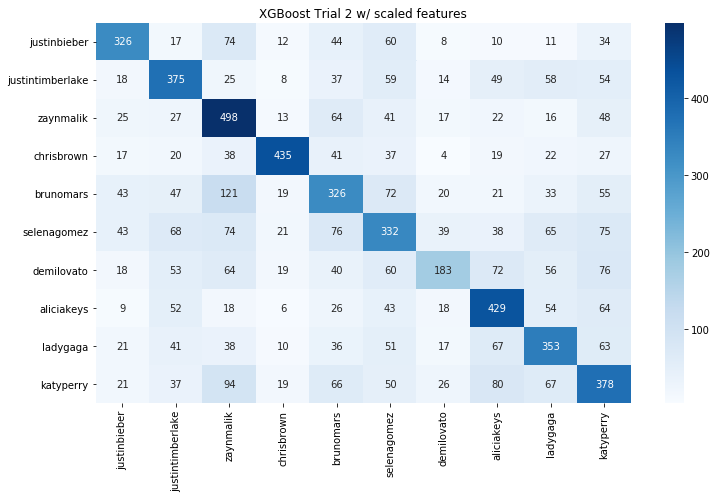

In [165]:
conf8 = confusion_matrix(y_test4, predlgb4, labels = artistlist)
df_lgr8 = pd.DataFrame(conf8, index = [i for i in artistlist], columns = [i for i in artistlist])
plt.figure(figsize=(12,7))
sns.heatmap(df_lgr8, annot=True, cmap='Blues', fmt = 'd')
plt.title('XGBoost Trial 2 w/ scaled features')
plt.show()

In [52]:
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [53]:
tweetlist = ' '.join(alltweets.cleaned[:12000])

In [54]:
tweetlist2 = ' '.join(alltweets.cleaned[12000:])

In [55]:
tweetlist

'all love over here aaron you got my support aaron carter i had your album when i was little and bumped the song aarons party i was like  if you need a hype man i got you xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires years ago today released purpose thank you thank you next is a bop my favorite song least this song is smash fire congrats on the new song  i have listened to this album  times in a row incredible praying for pittsburgh wishing everyone an amazing day wow  years thanks living in the us i see how this country affects not only people here but all around the world there are so many th  the end is fires whats not to love meet the newest bieber my baby sister bay bieber make sure you guys go see crazyrichasians this weekend so good congrats  just skate no brainer out nown   thank you  cupidmovie we will never let go of hope onelovemanchester praying for santa fe new game dont fall proud of my brother on his new al

In [56]:
len(tweetlist)

499007

In [57]:
tweetlist_doc = nlp(tweetlist)

In [58]:
tweetlist_doc2 = nlp(tweetlist2)

In [59]:
tweets = []
for tweet in tweetlist_doc.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
    
for tweet in tweetlist_doc2.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
print (tweets[20])
print('We have {} sentences and {} tokens.'.format(len(tweets), len(tweetlist_doc)
                                                   +len(tweetlist_doc2)))

['lyric', 'video', 'friend', 'friend', ' ', 'new', 'song', 'friend', 'hour', 'friend', 'new', 'music', 'thursday', 'noon']
We have 14336 sentences and 248719 tokens.


In [60]:
import gensim
from gensim.models import word2vec

start = time.time()
model = word2vec.Word2Vec(tweets, workers=4, min_count=10, window=6, sg=0, 
                         sample=.001, size=300, hs=1)
print(time.time()-start)

C:\Users\JChaotogo\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


1.5665061473846436


In [61]:
vocab = model.wv.vocab.keys()
print(model.wv.most_similar(positive=['party', 'katy']))


[('kat', 0.9367782473564148), ('presale', 0.925518274307251), ('vinyl', 0.9245393872261047), ('witness', 0.9241045713424683), ('tuesday', 0.9239237904548645), ('hour', 0.9236694574356079), ('final', 0.9229543209075928), ('kick', 0.9221539497375488), ('midnight', 0.9219321608543396), ('concert', 0.9206554889678955)]


The words to vec model doesn't give us accurate similarities most likely because of the small corpus. Some common words aren't represented in the vocabulary. However, this corpus could be helpful when added to a much larger model in order to add information about these artists as well as a slice of the music industry.

In [62]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

In [63]:
jb = ' '.join(finaltweets[finaltweets.artist=='justinbieber']['tokenized'])
jt = ' '.join(finaltweets[finaltweets.artist=='justintimberlake']['tokenized'])
zm = ' '.join(finaltweets[finaltweets.artist=='zaynmalik']['tokenized'])
cb = ' '.join(finaltweets[finaltweets.artist=='chrisbrown']['tokenized'])
bm = ' '.join(finaltweets[finaltweets.artist=='brunomars']['tokenized'])
sg = ' '.join(finaltweets[finaltweets.artist=='selenagomez']['tokenized'])
dl = ' '.join(finaltweets[finaltweets.artist=='demilovato']['tokenized'])
ak = ' '.join(finaltweets[finaltweets.artist=='aliciakeys']['tokenized'])
lg = ' '.join(finaltweets[finaltweets.artist=='ladygaga']['tokenized'])
kp = ' '.join(finaltweets[finaltweets.artist=='katyperry']['tokenized'])

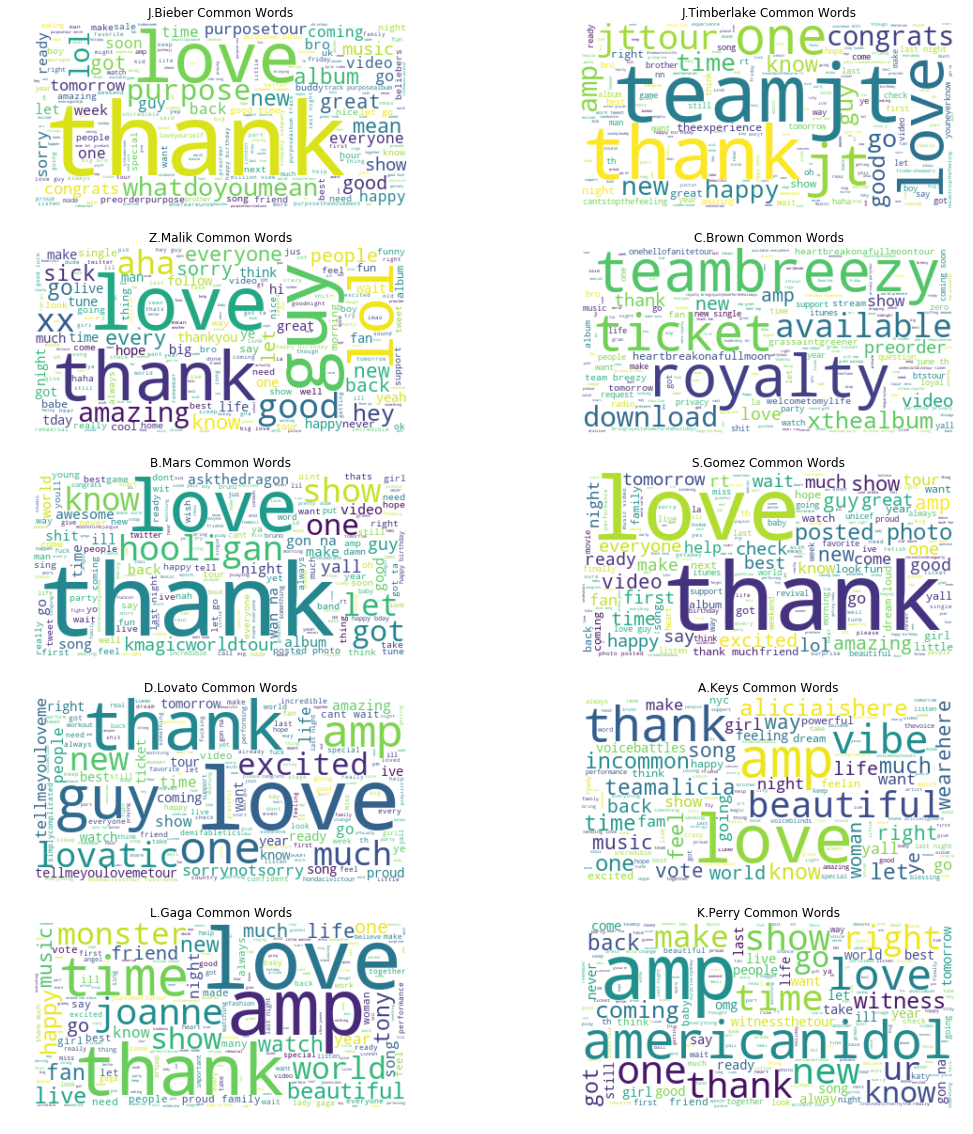

In [67]:
stopwords = set(STOPWORDS)
stopwords.update(['im', 'ha', 'see', 'today', 'tonight', 'day'])
jbw = WordCloud(stopwords=stopwords, background_color='white').generate(jb)
jtw = WordCloud(stopwords=stopwords, background_color='white').generate(jt)
zmw = WordCloud(stopwords=stopwords, background_color='white').generate(zm)
cbw = WordCloud(stopwords=stopwords, background_color='white').generate(cb)
bmw = WordCloud(stopwords=stopwords, background_color='white').generate(bm)
sgw = WordCloud(stopwords=stopwords, background_color='white').generate(sg)
dlw = WordCloud(stopwords=stopwords, background_color='white').generate(dl)
akw = WordCloud(stopwords=stopwords, background_color='white').generate(ak)
lgw = WordCloud(stopwords=stopwords, background_color='white').generate(lg)
kpw = WordCloud(stopwords=stopwords, background_color='white').generate(kp)

plt.figure(figsize=(18,20))
plt.subplot(5,2,1)
plt.imshow(jbw, interpolation='bilinear')
plt.title('J.Bieber Common Words')
plt.axis('off')
plt.subplot(5,2,2)
plt.imshow(jtw, interpolation='bilinear')
plt.title('J.Timberlake Common Words')
plt.axis('off')
plt.subplot(5,2,3)
plt.imshow(zmw, interpolation='bilinear')
plt.title('Z.Malik Common Words')
plt.axis('off')
plt.subplot(5,2,4)
plt.imshow(cbw, interpolation='bilinear')
plt.title('C.Brown Common Words')
plt.axis('off')
plt.subplot(5,2,5)
plt.imshow(bmw, interpolation='bilinear')
plt.title('B.Mars Common Words')
plt.axis('off')
plt.subplot(5,2,6)
plt.imshow(sgw, interpolation='bilinear')
plt.title('S.Gomez Common Words')
plt.axis('off')
plt.subplot(5,2,7)
plt.imshow(dlw, interpolation='bilinear')
plt.title('D.Lovato Common Words')
plt.axis('off')
plt.subplot(5,2,8)
plt.imshow(akw, interpolation='bilinear')
plt.title('A.Keys Common Words')
plt.axis('off')
plt.subplot(5,2,9)
plt.imshow(lgw, interpolation='bilinear')
plt.title('L.Gaga Common Words')
plt.axis('off')
plt.subplot(5,2,10)
plt.imshow(kpw, interpolation='bilinear')
plt.title('K.Perry Common Words')
plt.axis('off')

plt.show()

The most common words for most of the artists seem to be love and thank. This is expected because artist's often use twitter to thank their fans and show love to them. Interestingly, Chris Brown uses love and thank at a much lower frequency than his counterparts. This could have been a factor that the models took into account when classifying each tweet, thus contributing to the high predictibility of Chris Brown's tweets.

Some of the most frequent words in this corpus seem to have no spaces likely because they were used in a hashtag. Hashtags are commonly used when talking about popular topics which explains why these words appear so often.

In [65]:
#>put confusion matrices into heatmap
#>display # of words in a histogram
#>add other visualizations that reflect the features.
#add similarity scores cosine similarility
#>word cloud, plot of all the words in a dataset, words that are more common appear larger in a plot.
#>word cloud can show similarity between artists.
#show what each component is.
#topic modelling, think of additional applications of this project.
#clustering the tweets
#on report mention other things that are happenning with NLP and twitter feeds.